# Chord Analysis


In [1]:
import music21
import os
import sys
import json
from pathlib import Path
import pandas as pd
sys.path.append('../scripts')
import matplotlib.pyplot as plt
import utils

from constants import GUITAR_INSTRUMENT_PATCH_NUMBERS, TUNING_LABELS

%load_ext autoreload
%autoreload 2

## Create dictionaries for analysis files and music21 scores 

In [2]:
"""
Create a id:score map and id:analysis map
So we can easily look at both together with the same id
"""
analysis_map = {}
score_map = {}

total_files = 0
for root, dirs, files in os.walk("../dataset-converted-xml/"):
    for file in files:
        if file.endswith(".musicxml"):
            # Construct the full path to the file
            full_path = os.path.join(root, file)            
            identifier = utils.get_id_from_path(full_path)
            score = music21.converter.parse(full_path)
            score_map[identifier] = score
            analysis_map[identifier] = utils.lookup_analysis_for_file(full_path)
            total_files+=1
print("total files retrieved", total_files)

No analysis found for Open D/Metal/Slaughter - Old Man.
No analysis found for Open D/Pop/Susanne Sundfør - Gravity.
No analysis found for Open D/Pop/Tamino - Verses.
No analysis found for Drop D/Folk/Hannes Wader - Heute Hier Morgen Dort.
No analysis found for Drop D/Folk/Alexi Murdoch - All My Days.
No analysis found for Drop D/Folk/Richard Thompson - Beeswing.
No analysis found for Drop D/Folk/Misc Traditional - Spatter The Dew.
No analysis found for Drop D/Metal/Opeth - Porcelain Heart (ver 2 by xFilth).
No analysis found for Drop D/Blues/Hugh Laurie - The Firing Song.
No analysis found for Drop D/Blues/Joseph Spence - Glory Glory.
No analysis found for Drop D/Blues/Eric Bibb - Needed Time.
No analysis found for Drop D/Blues/Rory Block - Big Road Blues.
No analysis found for Drop D/Blues/B.B. King - Get Out Of My Back Woman.
No analysis found for Drop D/Pop/Bruno Mars - Just The Way You Are (ver 3 by Mr. Heater).
No analysis found for Drop D/Pop/Jason Mraz - I Wont Give Up.
No analy

## Get the score parts for a target tuning based on the scores and analysis maps

In [5]:
def get_score_parts_with_target_tuning(target_tuning, score_map, analysis_map):
    """
    Get all parts with the target tuning
    """
    parts_with_target_tuning = []

    for identifier, score in score_map.items():
        analysis = analysis_map[identifier]

        if analysis is None:
            # print("no analysis found for", identifier)
            continue

        for part in score.parts:
            for track in analysis["tracks"]:
                if tuple(track["tuning"]) == target_tuning and part.partName == track["name"] and track["instrument"] in GUITAR_INSTRUMENT_PATCH_NUMBERS:
                    # print("found guitar track", track["tuning"], track["instrument"])
                    parts_with_target_tuning.append(part)

    return parts_with_target_tuning

### Get the score parts for a specific tuning for each of the tuning tupes into a dict

In [8]:
tuning_parts_dict = {}

# Loop through each tuning label
for tuning_name, tuning_values in TUNING_LABELS.items():
  # Get the parts with the target tuning
  parts = get_score_parts_with_target_tuning(tuning_values, score_map, analysis_map)
  # Store the parts in the dictionary
  tuning_parts_dict[tuning_name] = parts

# Print the number of parts found for each tuning
for tuning_name, parts in tuning_parts_dict.items():
  print(f"Tuning: {tuning_name}, Number of parts: {len(parts)}")

Tuning: Standard, Number of parts: 156
Tuning: Drop D, Number of parts: 97
Tuning: Open D, Number of parts: 51
Tuning: Drop C, Number of parts: 57


## Get the final number of processed files in terms of genre and tuning

In [9]:
# Get the final numbers of tracks of each genre and each tuning
# Based on the analysis_output

output_json = "analysis_results.json"

with open(output_json, 'r') as file:
    data = json.load(file)

# part, parent_track_name, tuning, genre, 

rows = []

for song in data:
    filepath = song["filepath"]
    path = Path(filepath)

    for part in song["tracks"]:
      
      if part["instrument"] in GUITAR_INSTRUMENT_PATCH_NUMBERS:
        part_name = part["name"]
        parent_artist_song_name = path.stem
        tuning = utils.get_tuning_name(part["tuning"]) # get the tuning for the part.
        if (tuning == "Unknown Tuning"):
            continue
        genre = part["genre"]

        rows.append({
                "part": part_name,
                "parent_track_name": parent_artist_song_name,
                "tuning": tuning,
                "genre": genre
        })


df = pd.DataFrame(rows)

# Display the DataFrame
print(df.head())


              part         parent_track_name    tuning genre
0  Gtr.1 (12 str.)  Jeff Buckley - Vancouver    Open D  Rock
1    Gtr.2 (disto)  Jeff Buckley - Vancouver  Standard  Rock
2  Gtr.3 (12 str.)  Jeff Buckley - Vancouver    Open D  Rock
3         Guitar 1     Pearl Jam - Even Flow    Open D  Rock
4         Guitar 2     Pearl Jam - Even Flow  Standard  Rock


In [10]:
# Calculate the total number of songs
total_songs = df['parent_track_name'].nunique()
print(f"Total number of songs: {total_songs}")

# Calculate the total number of parts
total_parts = len(df)
print(f"Total number of parts: {total_parts}")

Total number of songs: 159
Total number of parts: 339


Total number of songs per genre:
genre
Blues    22
Folk     25
Jazz     19
Metal    31
Pop      23
Rock     39
Name: parent_track_name, dtype: int64


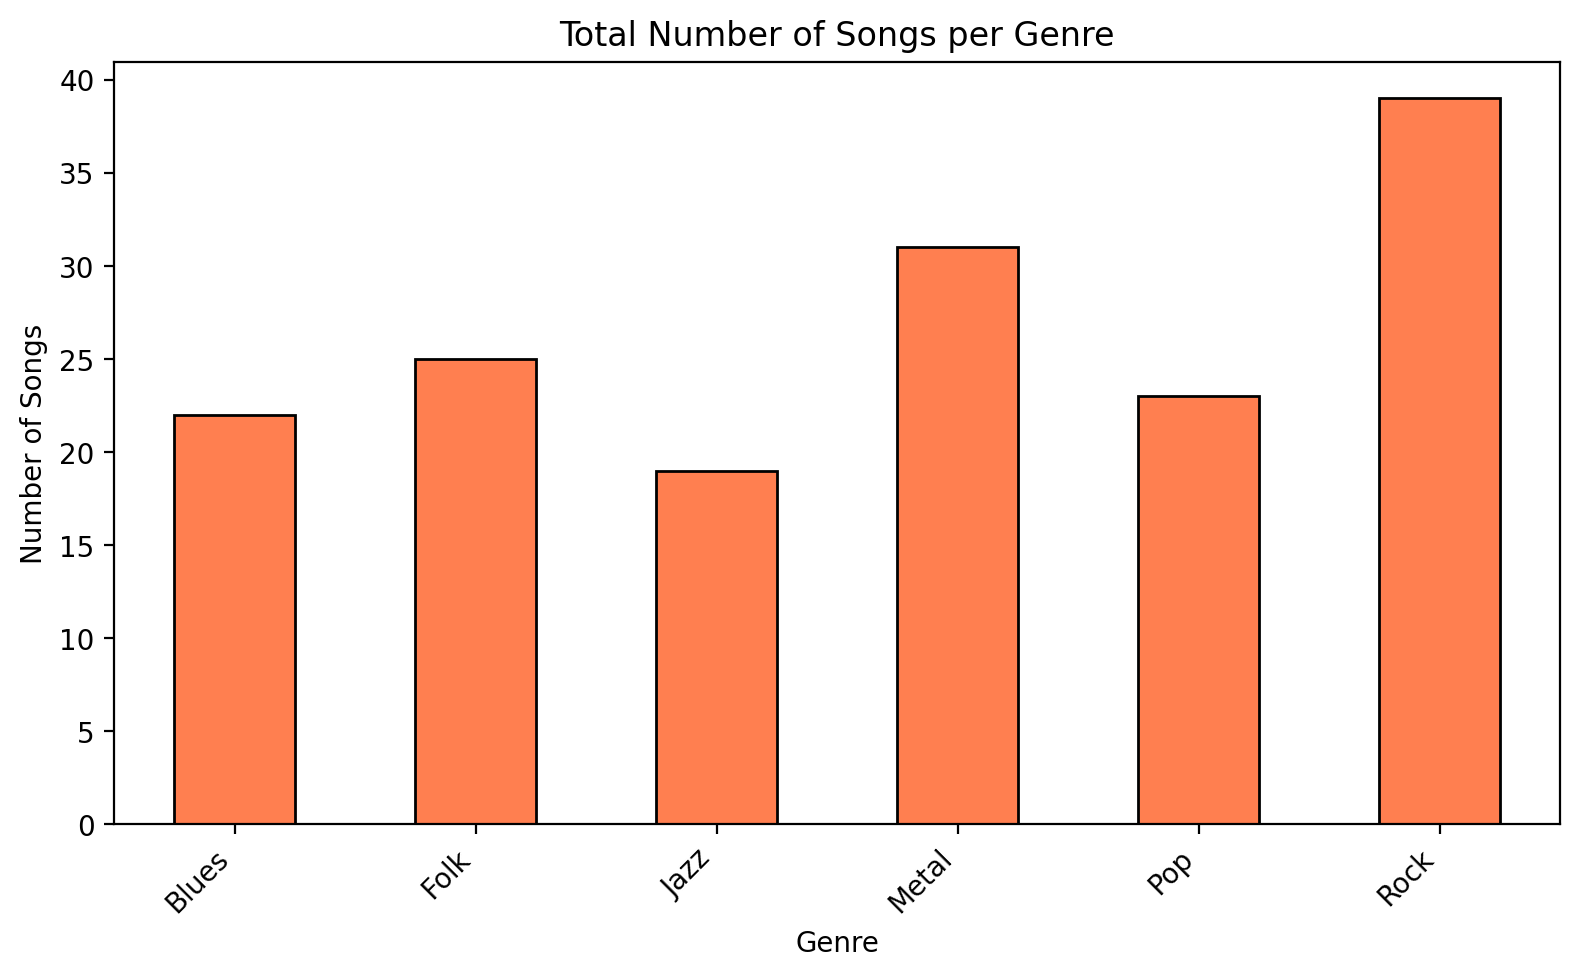

Total number of songs per tuning:
tuning
Drop C      17
Drop D      51
Open D      34
Standard    72
Name: parent_track_name, dtype: int64


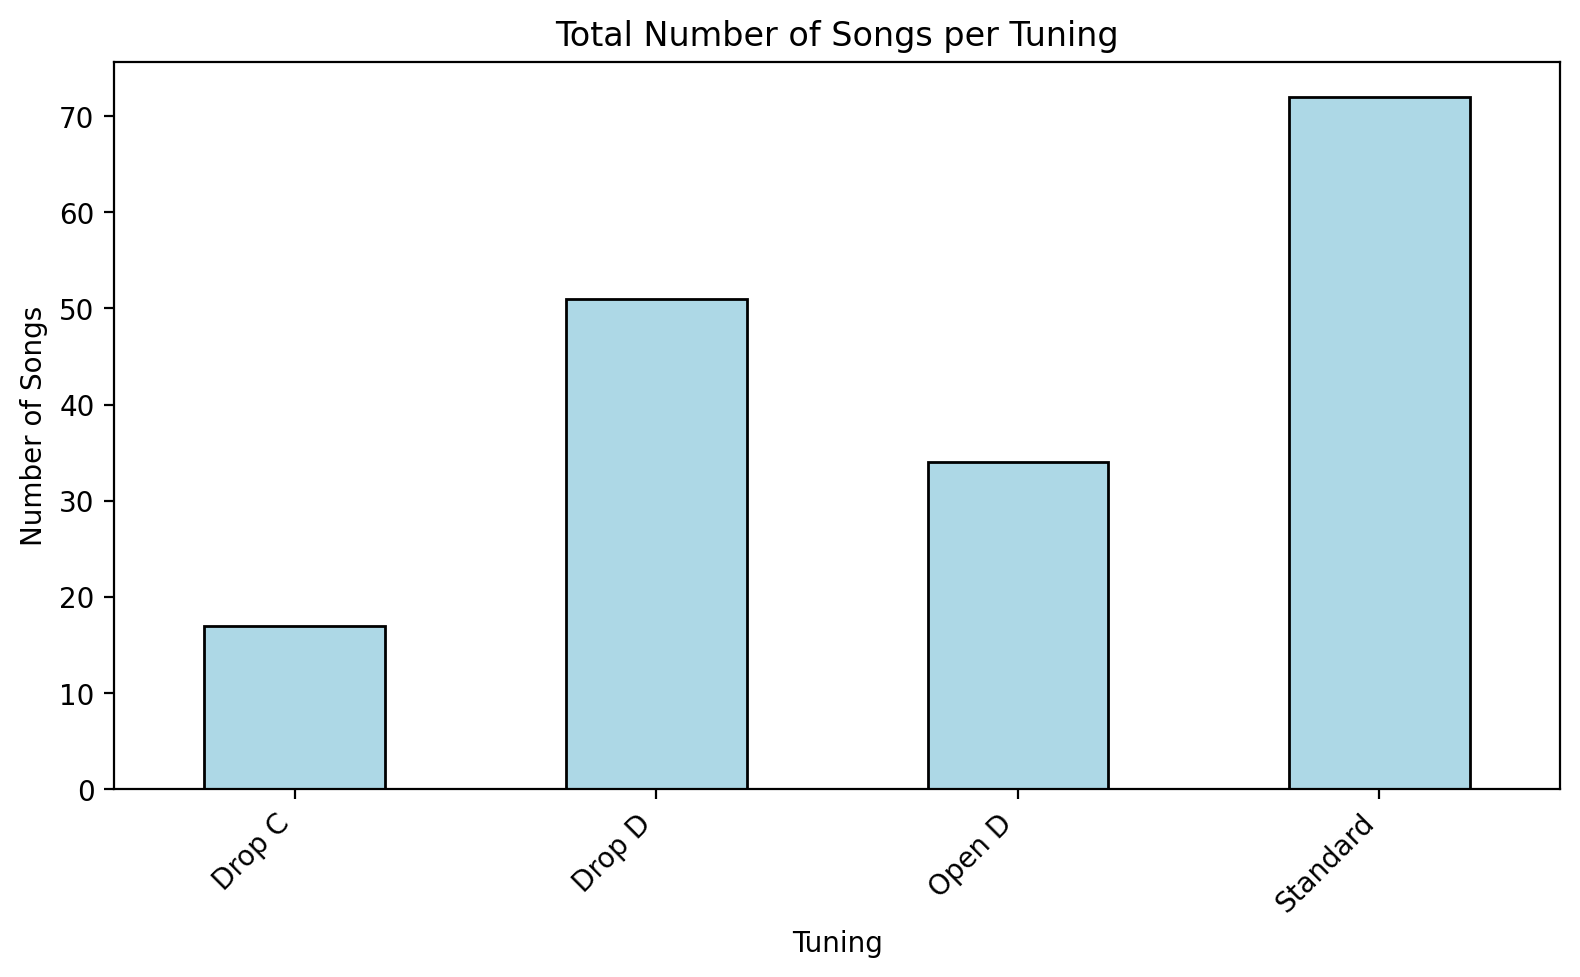

Number of songs for each genre per tuning:
genre     Blues  Folk  Jazz  Metal  Pop  Rock
tuning                                       
Drop C        0     0     0      7    1     9
Drop D        7     7     8     11    8    10
Open D        6    10     0      4    4    10
Standard     11    12    12     10   11    16


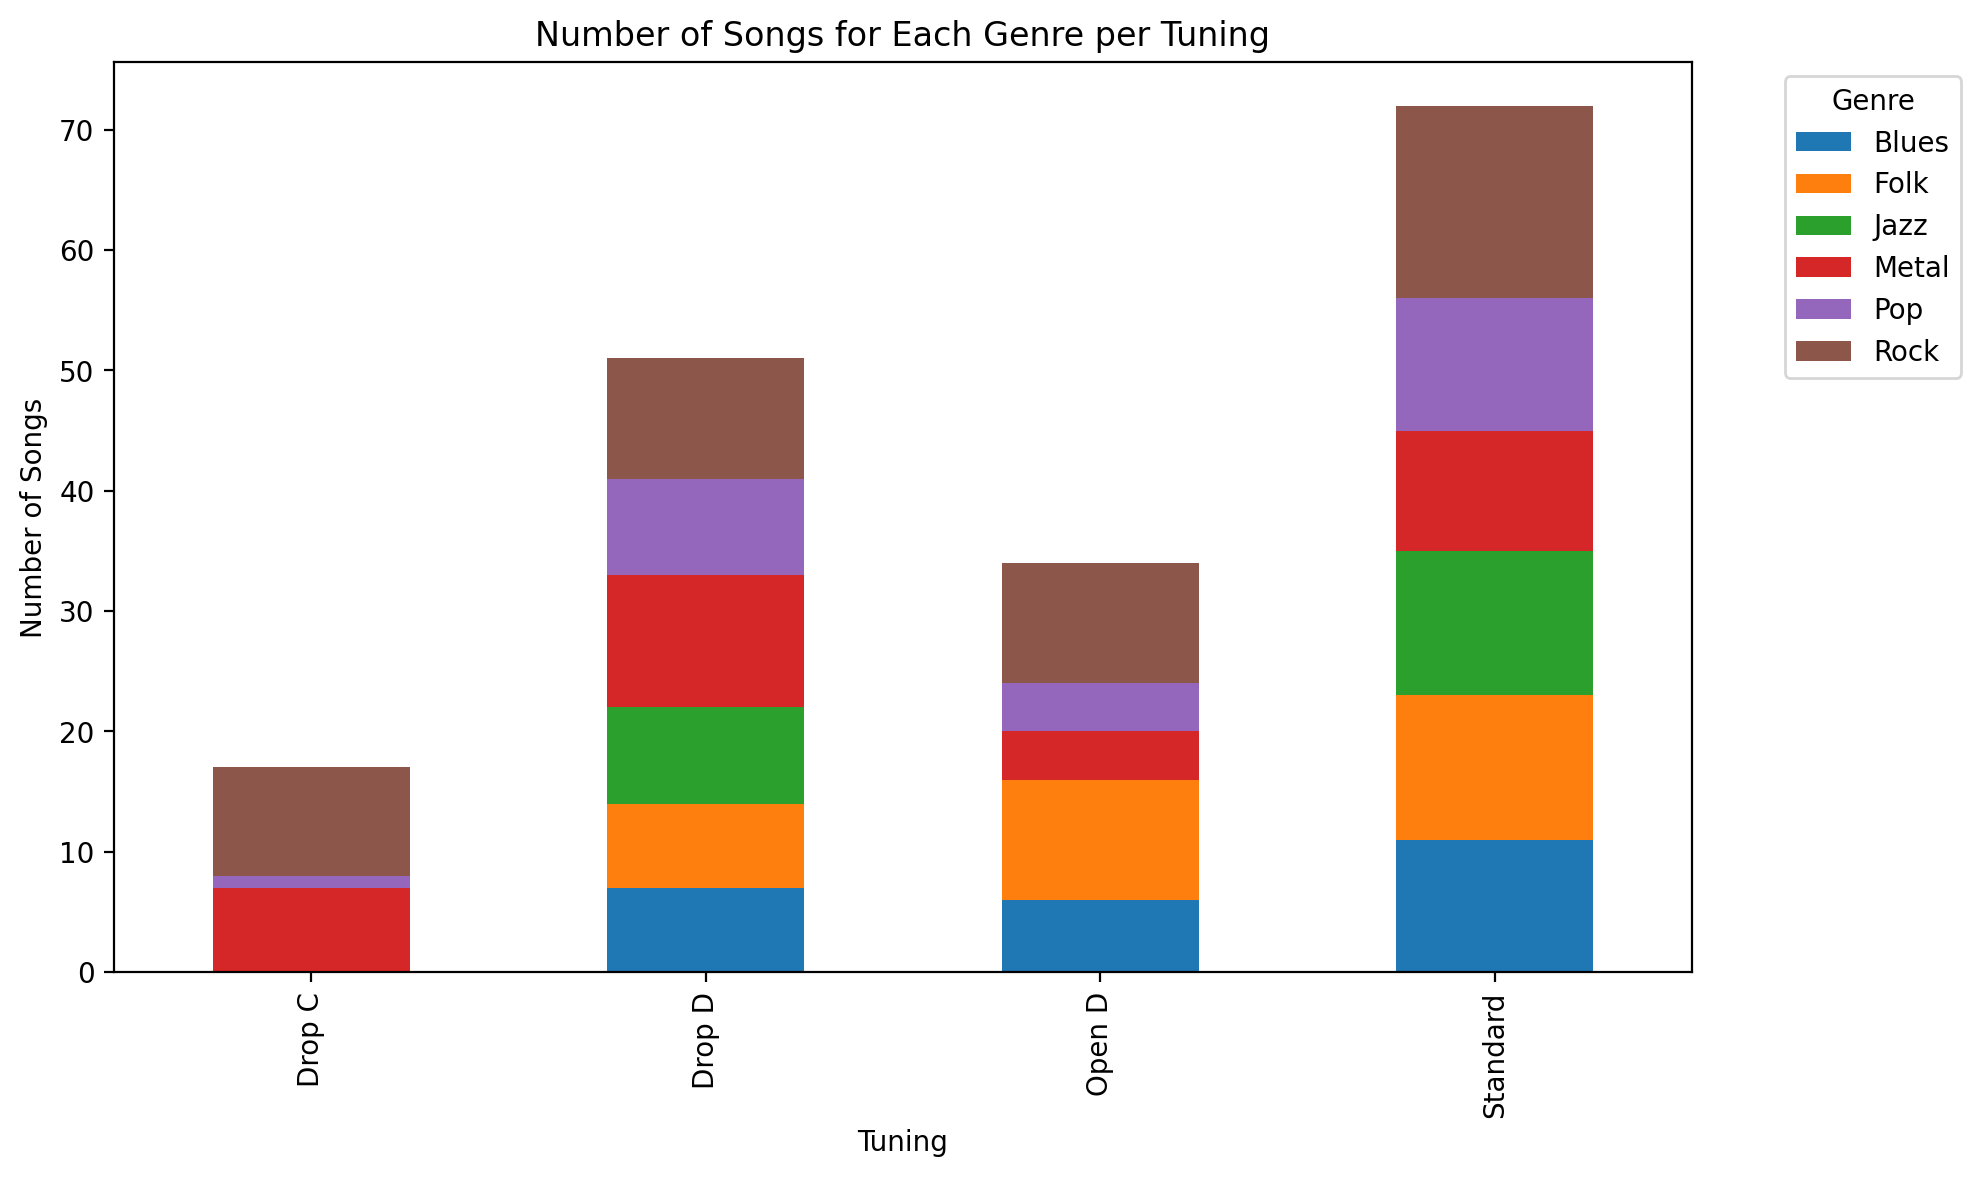

In [11]:
# Calculate the total number of songs per genre
songs_per_genre = df.groupby('genre')['parent_track_name'].nunique()

# Display the results
print("Total number of songs per genre:")
print(songs_per_genre)

songs_per_genre.plot(kind='bar', figsize=(8, 5), color='coral', edgecolor='black')
plt.title("Total Number of Songs per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


# Calculate the total number of songs per tuning
songs_per_tuning = df.groupby('tuning')['parent_track_name'].nunique()

# Display the results
print("Total number of songs per tuning:")
print(songs_per_tuning)

# Visualize the results
songs_per_tuning.plot(kind='bar', figsize=(8, 5), color='lightblue', edgecolor='black')
plt.title("Total Number of Songs per Tuning")
plt.xlabel("Tuning")
plt.ylabel("Number of Songs")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

# Calculate the number of songs for each genre per tuning
songs_per_genre_tuning = df.groupby(['tuning', 'genre'])['parent_track_name'].nunique().unstack(fill_value=0)

# Display the results
print("Number of songs for each genre per tuning:")
print(songs_per_genre_tuning)

# Visualize the results
songs_per_genre_tuning.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Number of Songs for Each Genre per Tuning")
plt.xlabel("Tuning")
plt.ylabel("Number of Songs")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### frequencies of genre, tuning based on parts

Number of each genre for each tuning (in terms of parts):
genre     Blues  Folk  Jazz  Metal  Pop  Rock
tuning                                       
Drop C        0     0     0     17    3    25
Drop D       11     9     8     31   12    24
Open D        8    10     0      7    6    14
Standard     25    27    18     23   25    36

Total number of each tuning type (in terms of Parts):
tuning
Standard    154
Drop D       95
Open D       45
Drop C       45
Name: count, dtype: int64


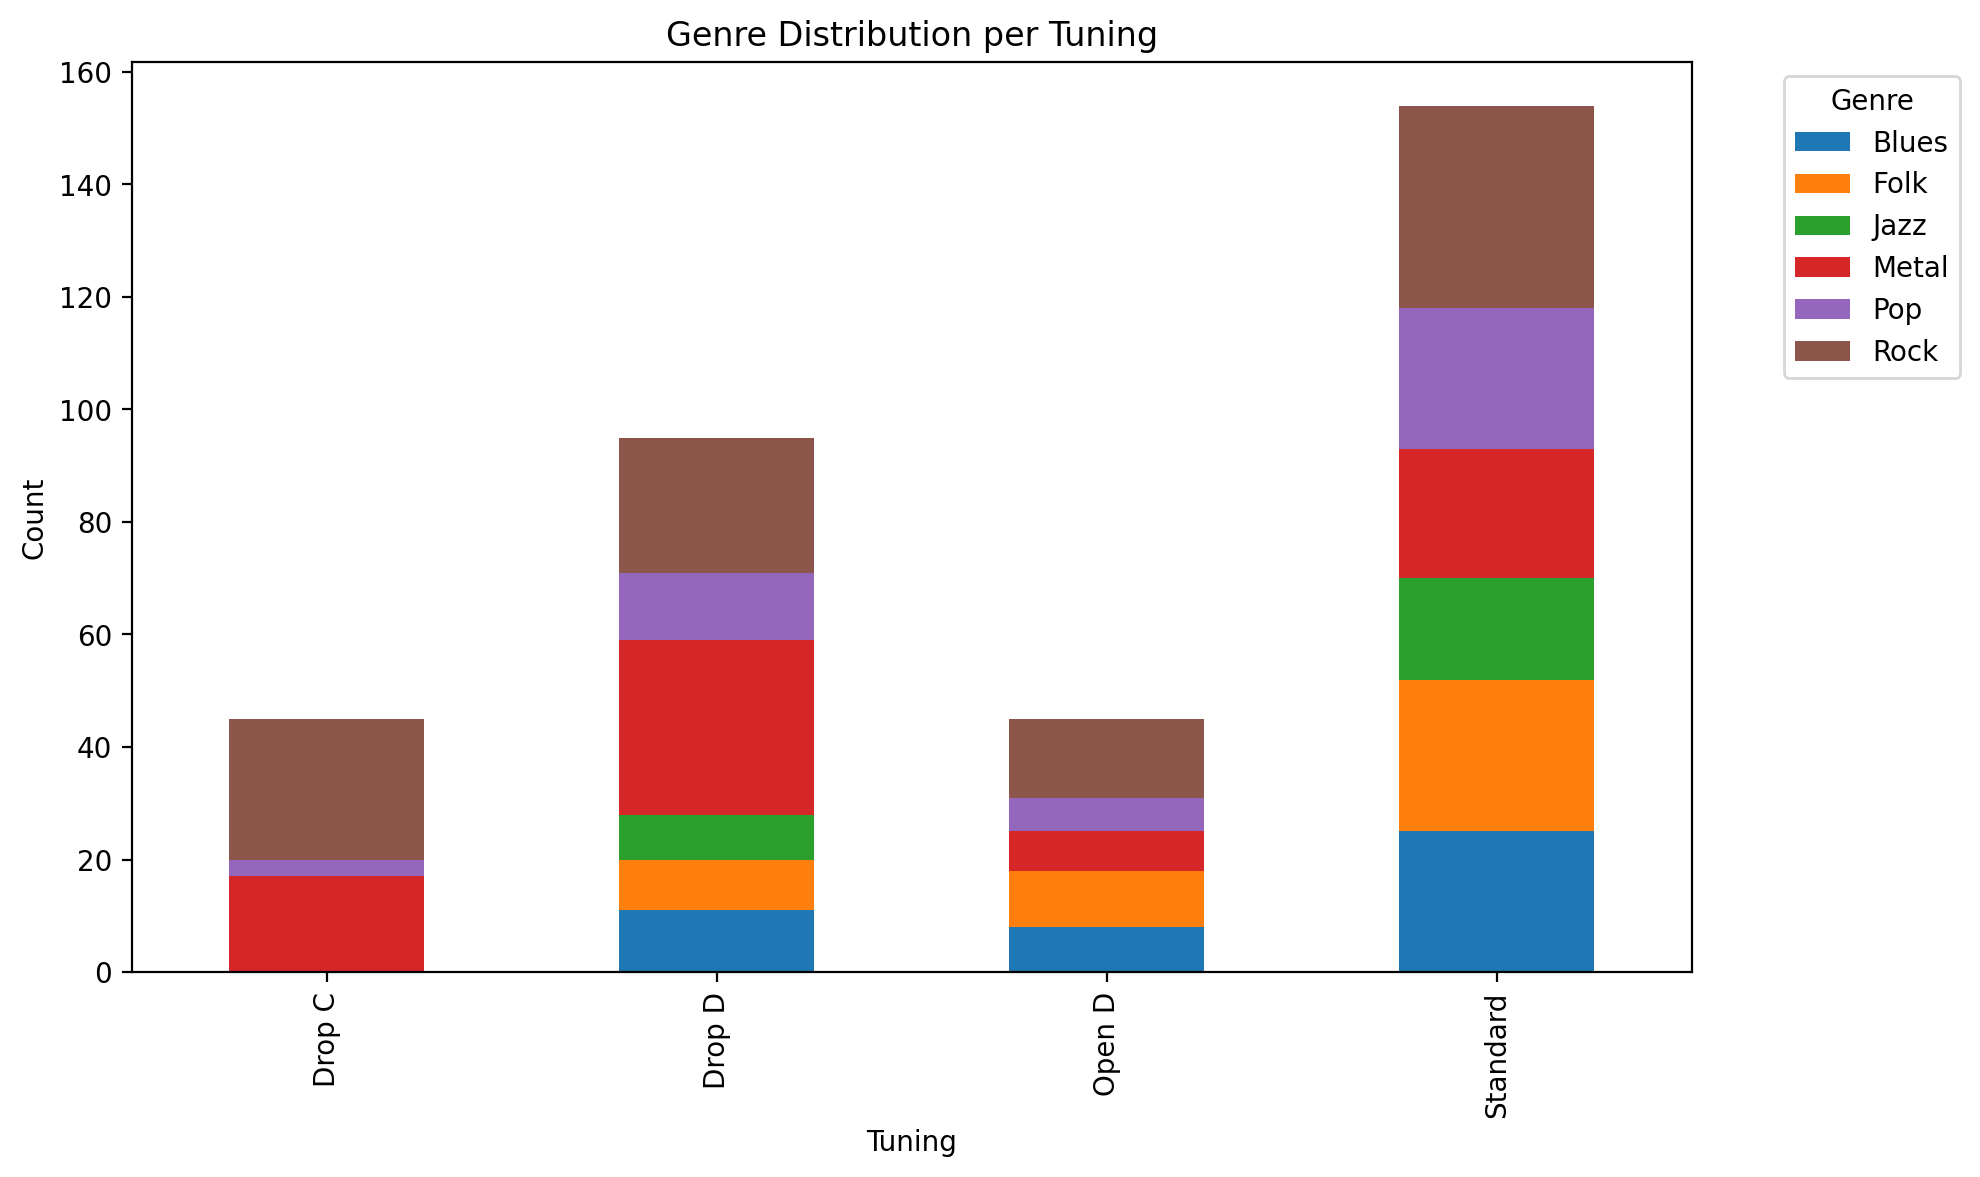

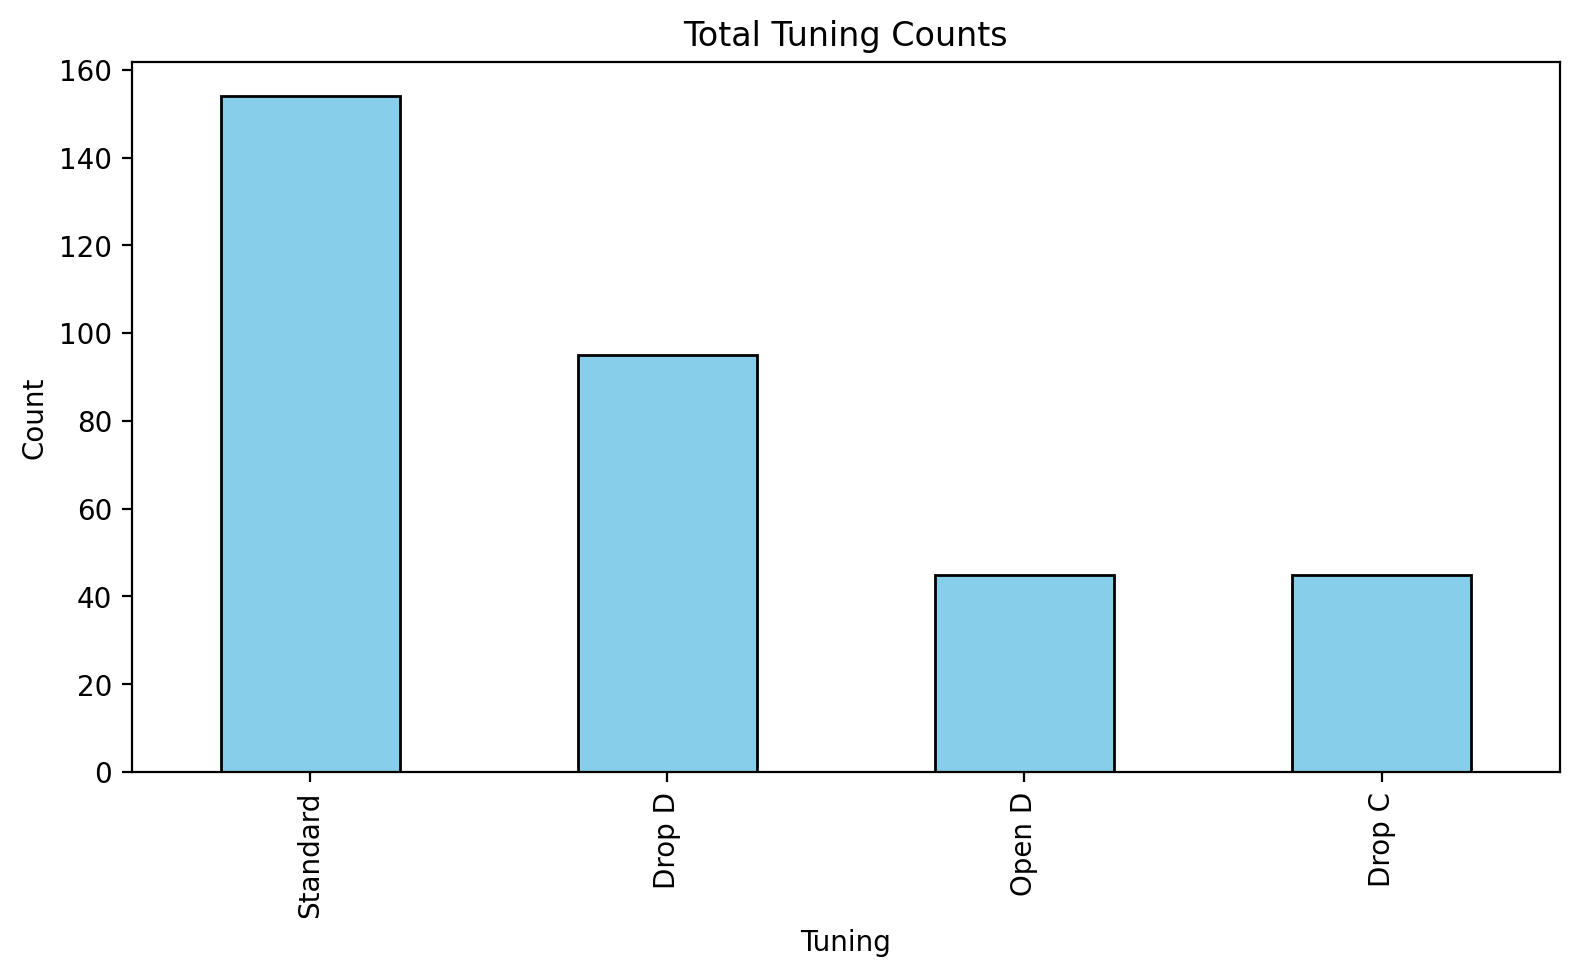

In [12]:
# Calculate statistics for genres per tuning and overall tuning counts
genre_tuning_stats = df.groupby(['tuning', 'genre']).size().unstack(fill_value=0)
tuning_counts = df['tuning'].value_counts()

# Display the statistics
print("Number of each genre for each tuning (in terms of parts):")
print(genre_tuning_stats)

print("\nTotal number of each tuning type (in terms of Parts):")
print(tuning_counts)

# Optionally, visualize the statistics
import matplotlib.pyplot as plt

# Plot genre counts per tuning
genre_tuning_stats.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Genre Distribution per Tuning")
plt.xlabel("Tuning")
plt.ylabel("Count")
plt.legend(title="Genre", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot total tuning counts
tuning_counts.plot(kind='bar', figsize=(8, 5), color='skyblue', edgecolor='black')
plt.title("Total Tuning Counts")
plt.xlabel("Tuning")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

## Get the chord changes

In [13]:
import matplotlib.pyplot as plt
from collections import defaultdict

def get_chord_changes(parts_with_target_guitar, normalise=True):
    """
    Get the frequency dict of chord changes by commonName,
    optionally normalized per part.
    """
    chord_changes = defaultdict(float)
    num_parts = len(parts_with_target_guitar)

    for part in parts_with_target_guitar:
        part_changes = defaultdict(int)
        last_chord_signature = None

        for element in part.flat.notes:
            if isinstance(element, music21.chord.Chord):
                current_signature = (tuple(element.normalOrder), element.bass().nameWithOctave)

                if current_signature != last_chord_signature:
                    name = element.commonName or "Unknown"
                    part_changes[name] += 1
                    last_chord_signature = current_signature

        if normalise:
            total = sum(part_changes.values())
            if total > 0:
                for key in part_changes:
                    chord_changes[key] += (part_changes[key] / total) * 100  # Normalize to 100 per part
        else:
            for key in part_changes:
                chord_changes[key] += part_changes[key]

    # average percentages across number of parts
    if normalise and num_parts > 0:
        for key in chord_changes:
            chord_changes[key] /= num_parts

    return chord_changes

def plot_top_n_chord_changes(chord_changes, n=10, normalise=True):
    """
    Plot the top N chord changes from the chord_changes dictionary.
    If normalise=True, values are interpreted as averaged percentages across parts.
    """
    # Get top N chord changes sorted by value
    topn = sorted(chord_changes.items(), key=lambda x: x[1], reverse=True)[:n]
    chord_names = [item[0] for item in topn]
    counts = [item[1] for item in topn]

    # Create the bar plot
    plt.figure(figsize=(10, 5))
    bars = plt.bar(chord_names, counts, color='skyblue', edgecolor='black')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel('Chord Name')

    # Axis labels and title
    if normalise:
        plt.ylabel('Average (%) of Chord Changes per Part')
        plt.title(f'Top {n} Chord Changes (Normalised per Part)')
    else:
        plt.ylabel('Total Chord Change Count')
        plt.title(f'Top {n} Chord Changes (Raw Counts)')

    plt.tight_layout()
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    # Add value labels on top of bars, formatted better
    for bar in bars:
        height = bar.get_height()
        label = f'{height:.2f}%' if normalise else f'{int(height)}'
        plt.text(bar.get_x() + bar.get_width() / 2, height + 0.5, label,
                 ha='center', va='bottom', fontsize=9)

    plt.show()


##  Inidvidual plots for chord chnages

/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


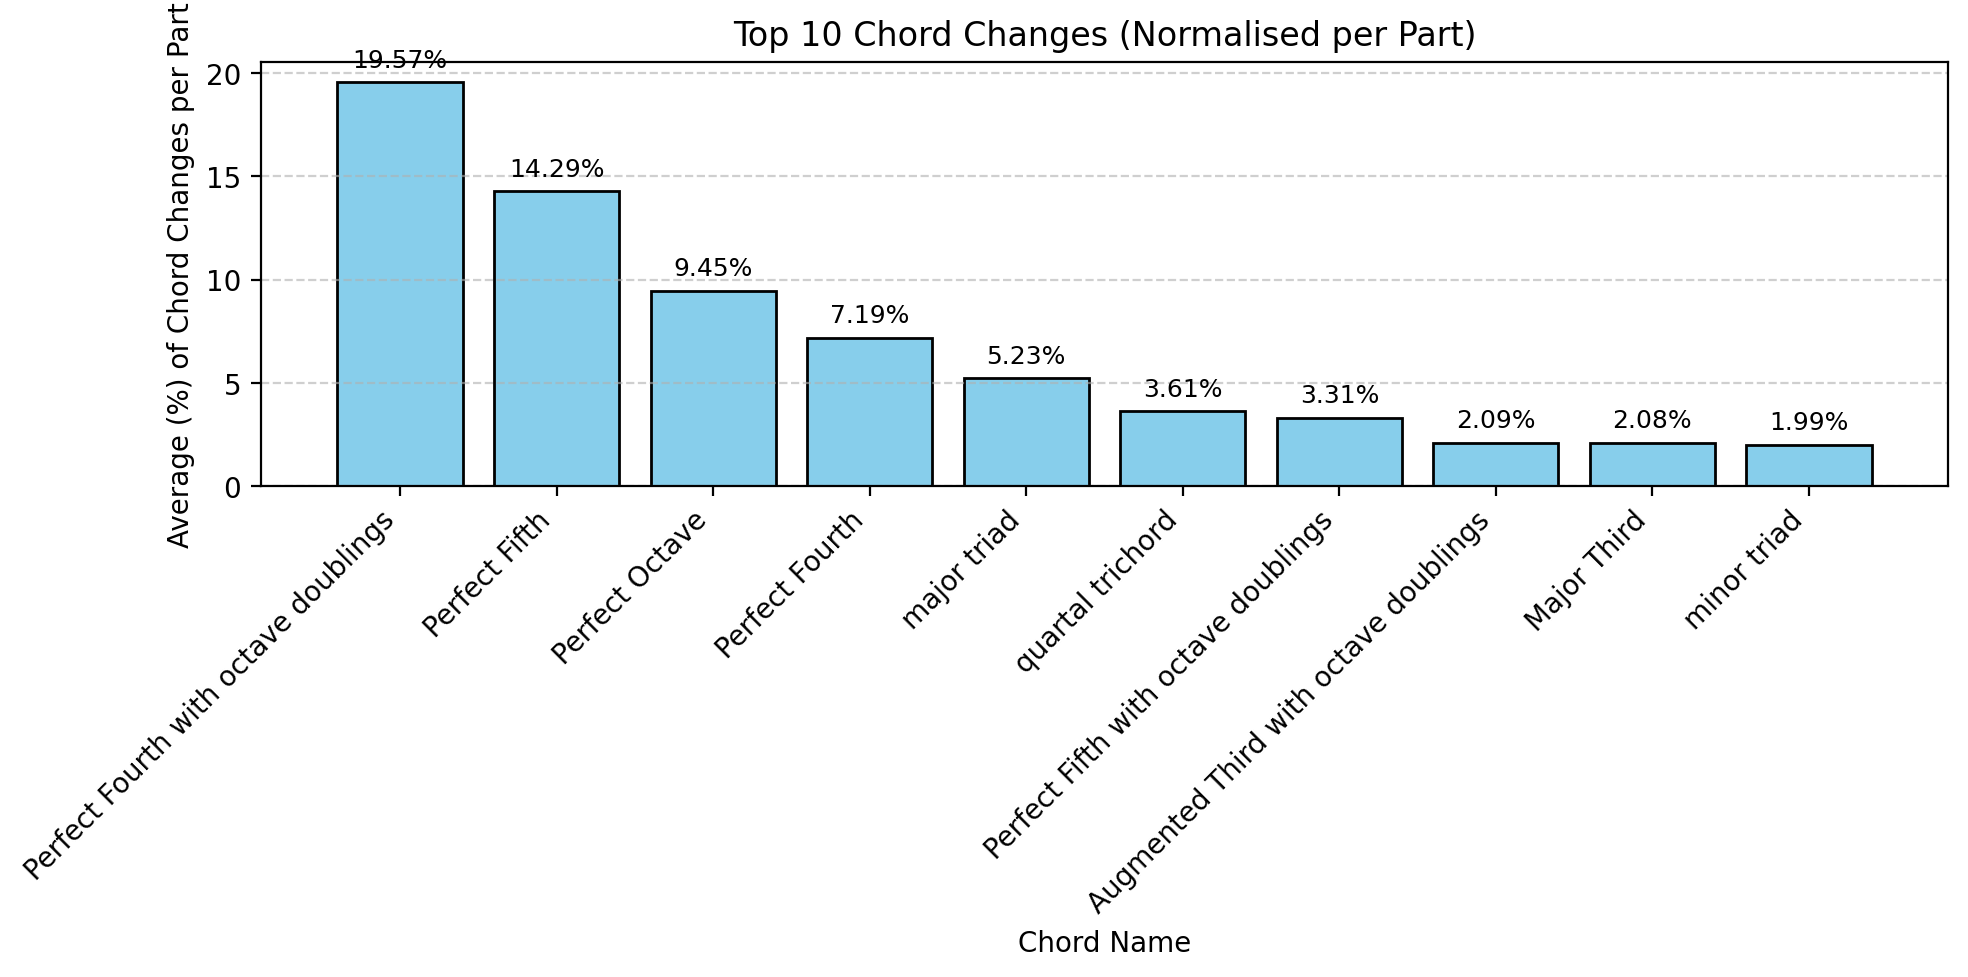

In [14]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Drop D"]))

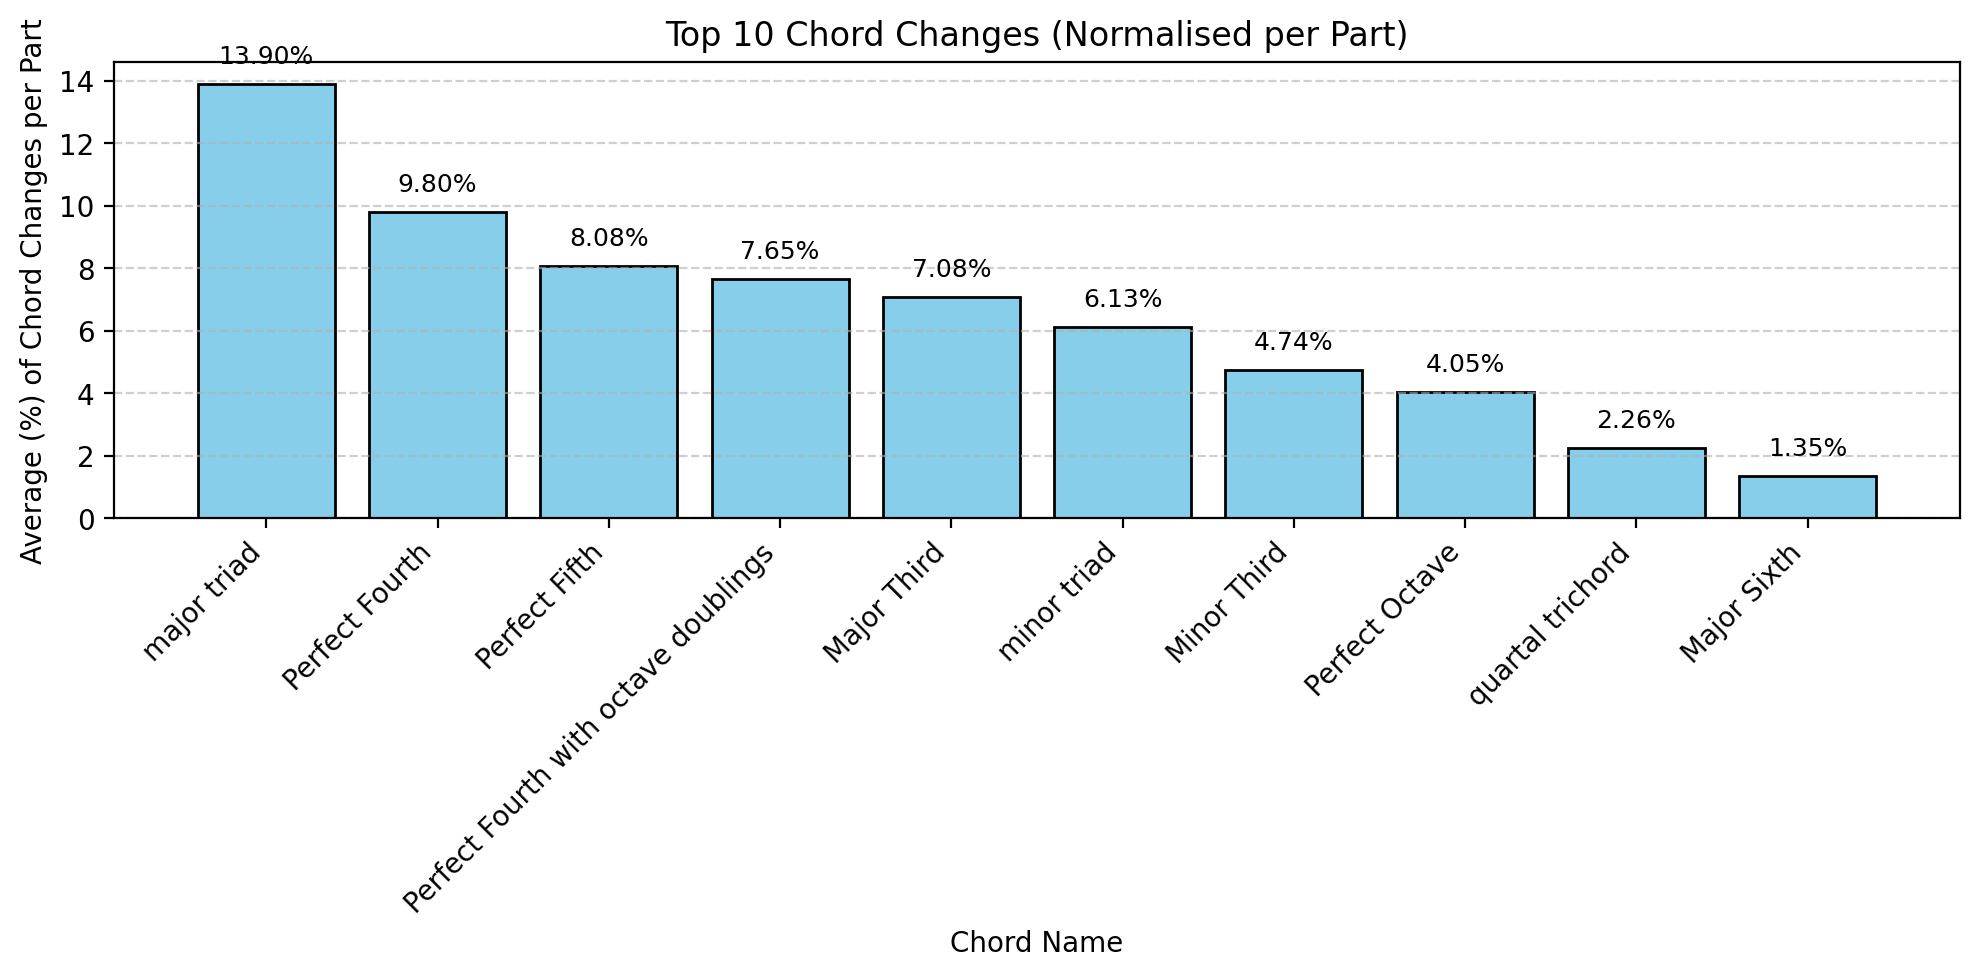

In [15]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Standard"]))

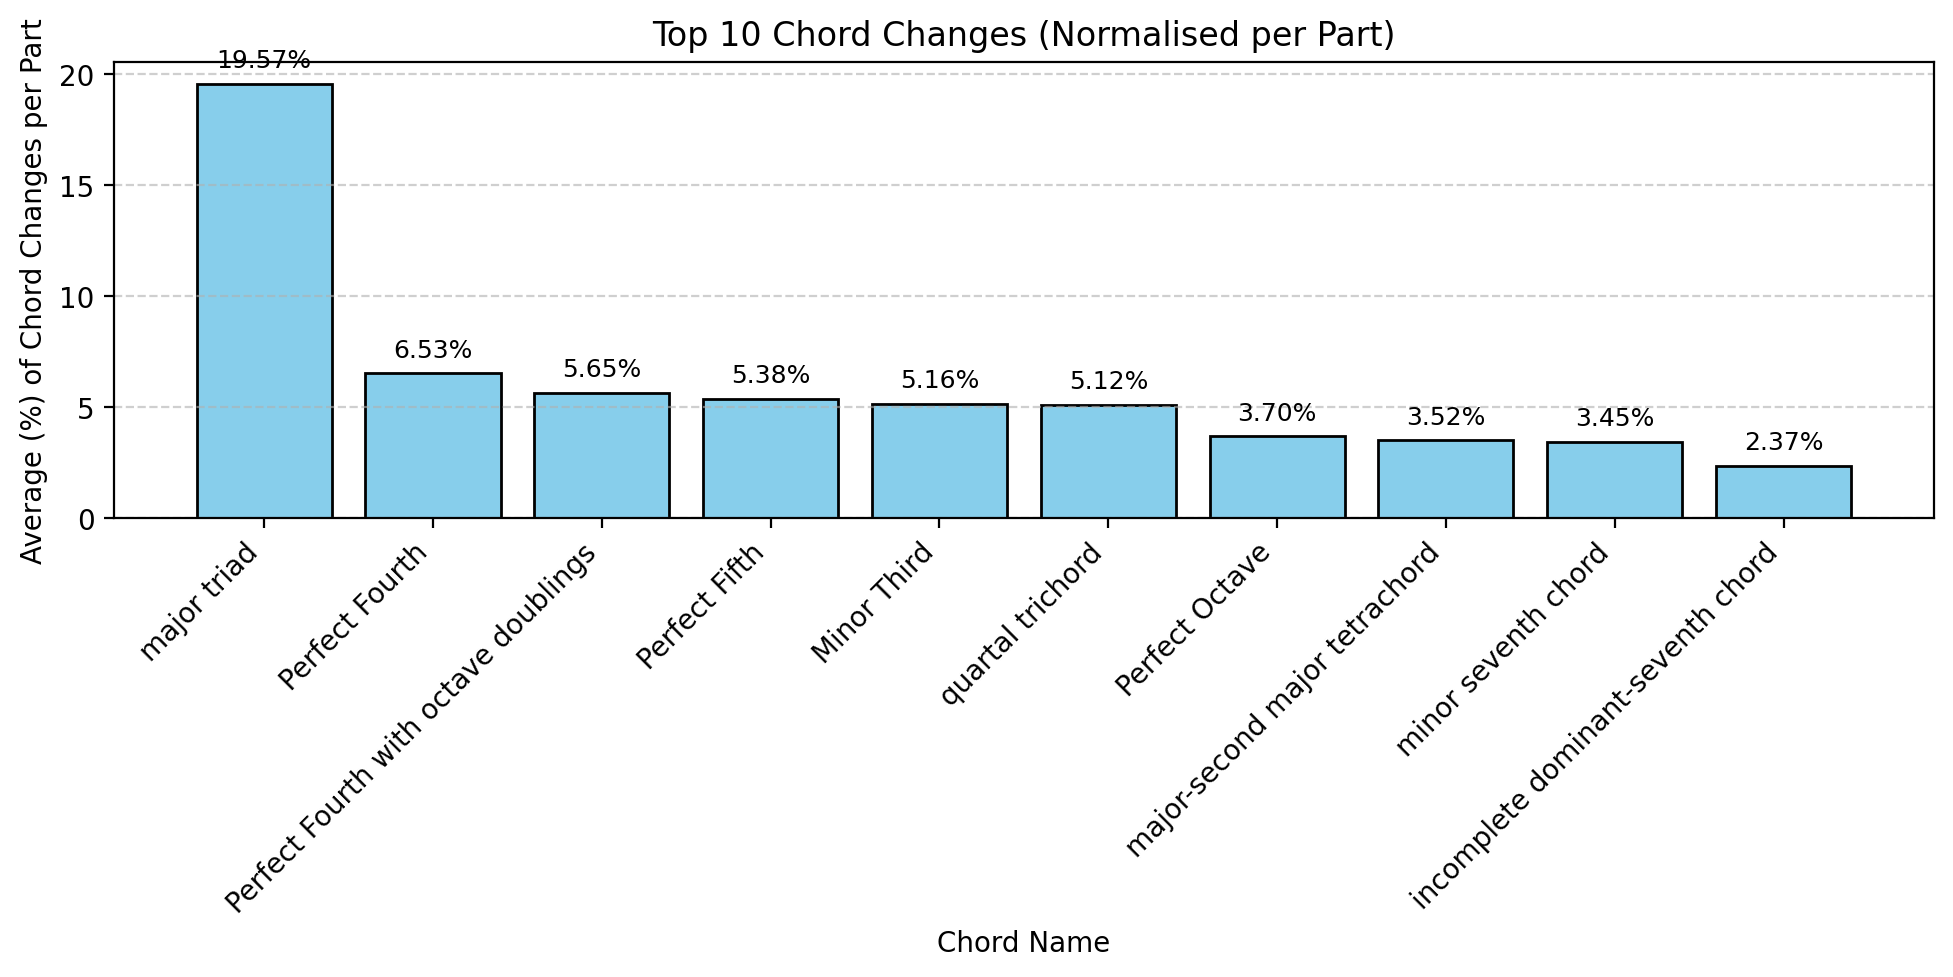

In [123]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Open D"]))

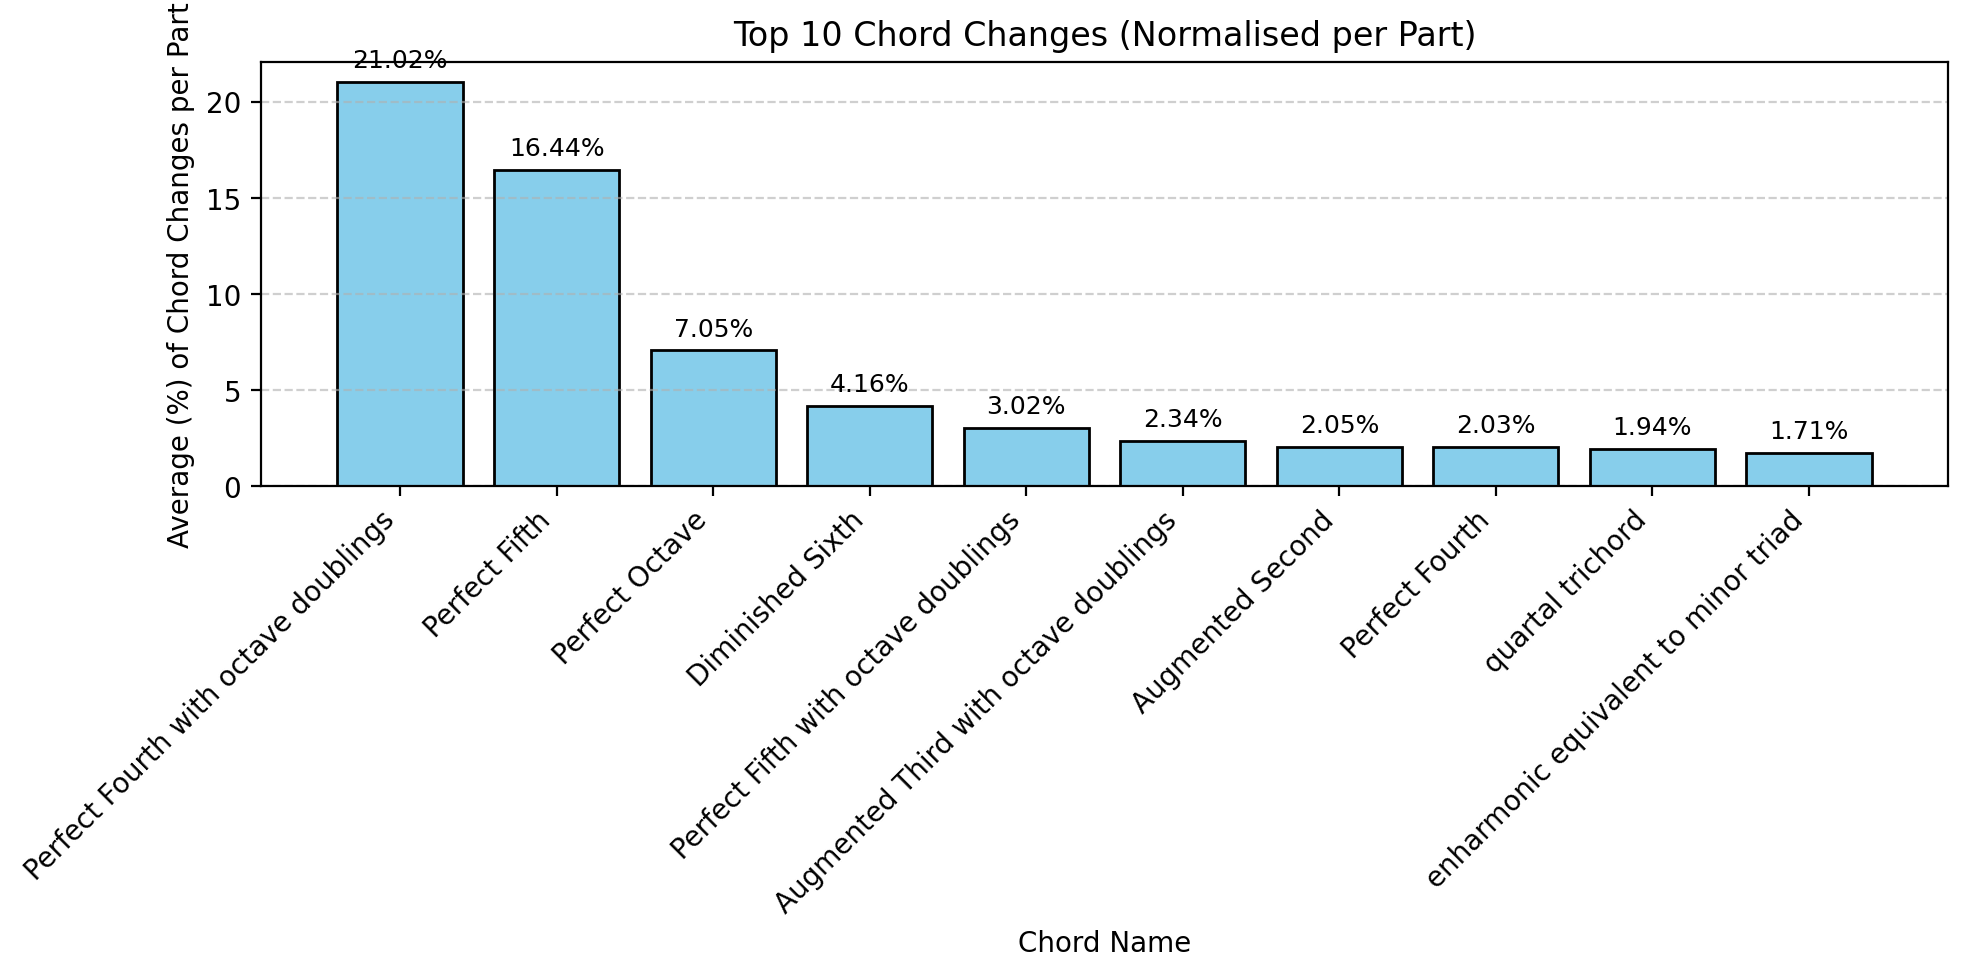

In [ ]:
plot_top_n_chord_changes(get_chord_changes(tuning_parts_dict["Drop C"]))

In [16]:
import pandas as pd

# get top n chord changes sorted by count
topn = sorted(get_chord_changes(tuning_parts_dict["Drop C"]).items(), key=lambda x: x[1], reverse=True)[:10]

df = pd.DataFrame(topn, columns=["Chord Name", "Count"])
print(df.to_string(index=False))

                           Chord Name     Count
 Perfect Fourth with octave doublings 21.016032
                        Perfect Fifth 16.444673
                       Perfect Octave  7.053219
                     Diminished Sixth  4.157970
  Perfect Fifth with octave doublings  3.021374
Augmented Third with octave doublings  2.339008
                     Augmented Second  2.046784
                       Perfect Fourth  2.025749
                     quartal trichord  1.944105
 enharmonic equivalent to minor triad  1.706289


# Horizontal bar comparison plot


In [48]:
import numpy as np
from utils import setup_nice_plot


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from utils import setup_nice_plot

def plot_vertical_bar_comparison(tuning_chord_dict, topn=5):
    """
    Shows vertical grouped bar chart comparing top N chord changes across tunings.
    """
    setup_nice_plot()
    # Find top N global chords across all tunings
    all_chords = {}
    for chord_changes in tuning_chord_dict.values():
        for chord, value in chord_changes.items():
            all_chords[chord] = all_chords.get(chord, 0) + value
    top_chords = sorted(all_chords.items(), key=lambda x: x[1], reverse=True)[:topn]
    selected_chords = [chord for chord, _ in top_chords]

    tunings = list(tuning_chord_dict.keys())
    n_tunings = len(tunings)
    indices = np.arange(topn)
    bar_width = 0.8 / n_tunings

    plt.figure(figsize=(10, 8))  # Adjusted for vertical layout

    for i, tuning in enumerate(tunings):
        chord_changes = tuning_chord_dict[tuning]
        values = [chord_changes.get(chord, 0) for chord in selected_chords]
        plt.bar(indices + i * bar_width, values, width=bar_width, label=tuning)

    # modified_labels = [label.replace("Perfect", "P") for label in selected_chords]
    # plt.xticks(indices + bar_width * (n_tunings - 1) / 2, modified_labels, rotation=45, ha='right')
    plt.xticks(indices + bar_width * (n_tunings - 1) / 2, selected_chords, rotation=45, ha='right')
    plt.ylabel('Average Percentage of Chords per Part (%)')
    plt.title('Chord Usage Comparison Across Tunings')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.tight_layout()

    save_path = "../figures/chord-usage-comparison-across-tunings.png"
    save_path_pdf = "../figures/chord-usage-comparison-across-tunings.pdf"

    plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.savefig(save_path_pdf, dpi=300, bbox_inches='tight')

    plt.show()

/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


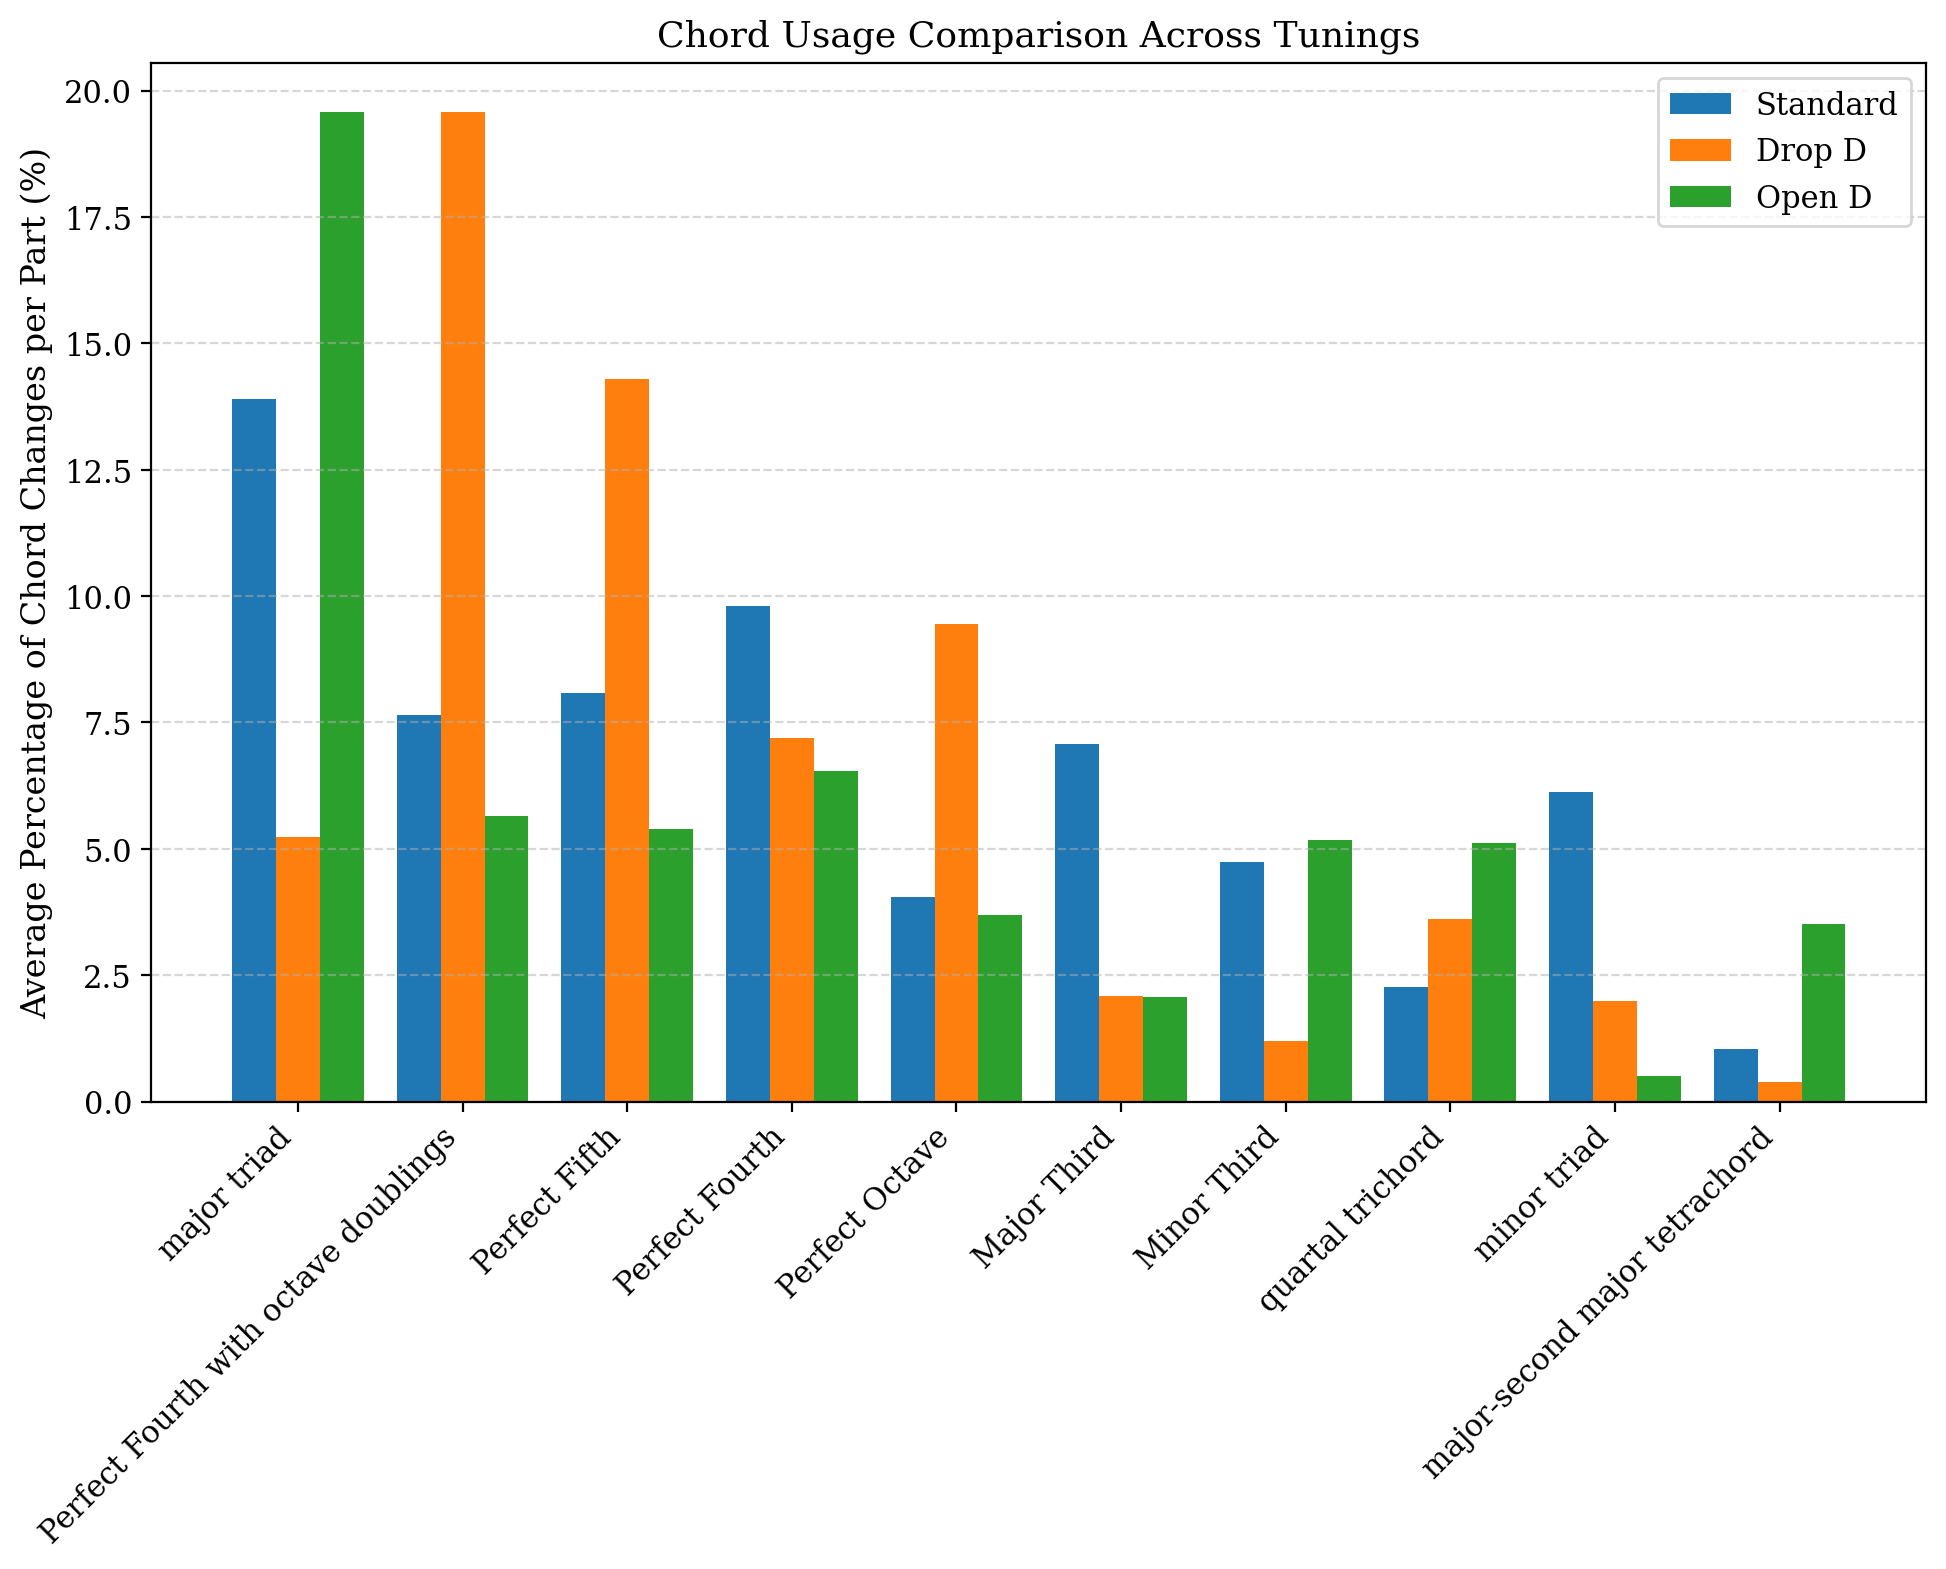

In [43]:
tuning_chord_dict = {
    "Standard": get_chord_changes(tuning_parts_dict["Standard"]),
    "Drop D": get_chord_changes(tuning_parts_dict["Drop D"]),
    "Open D": get_chord_changes(tuning_parts_dict["Open D"]),
    # "Drop C": get_chord_changes(tuning_parts_dict["Drop C"]),
}
plot_vertical_bar_comparison(tuning_chord_dict, topn=10)

# Chord changes

Figure saved to figures/chord_comparison_top5.png


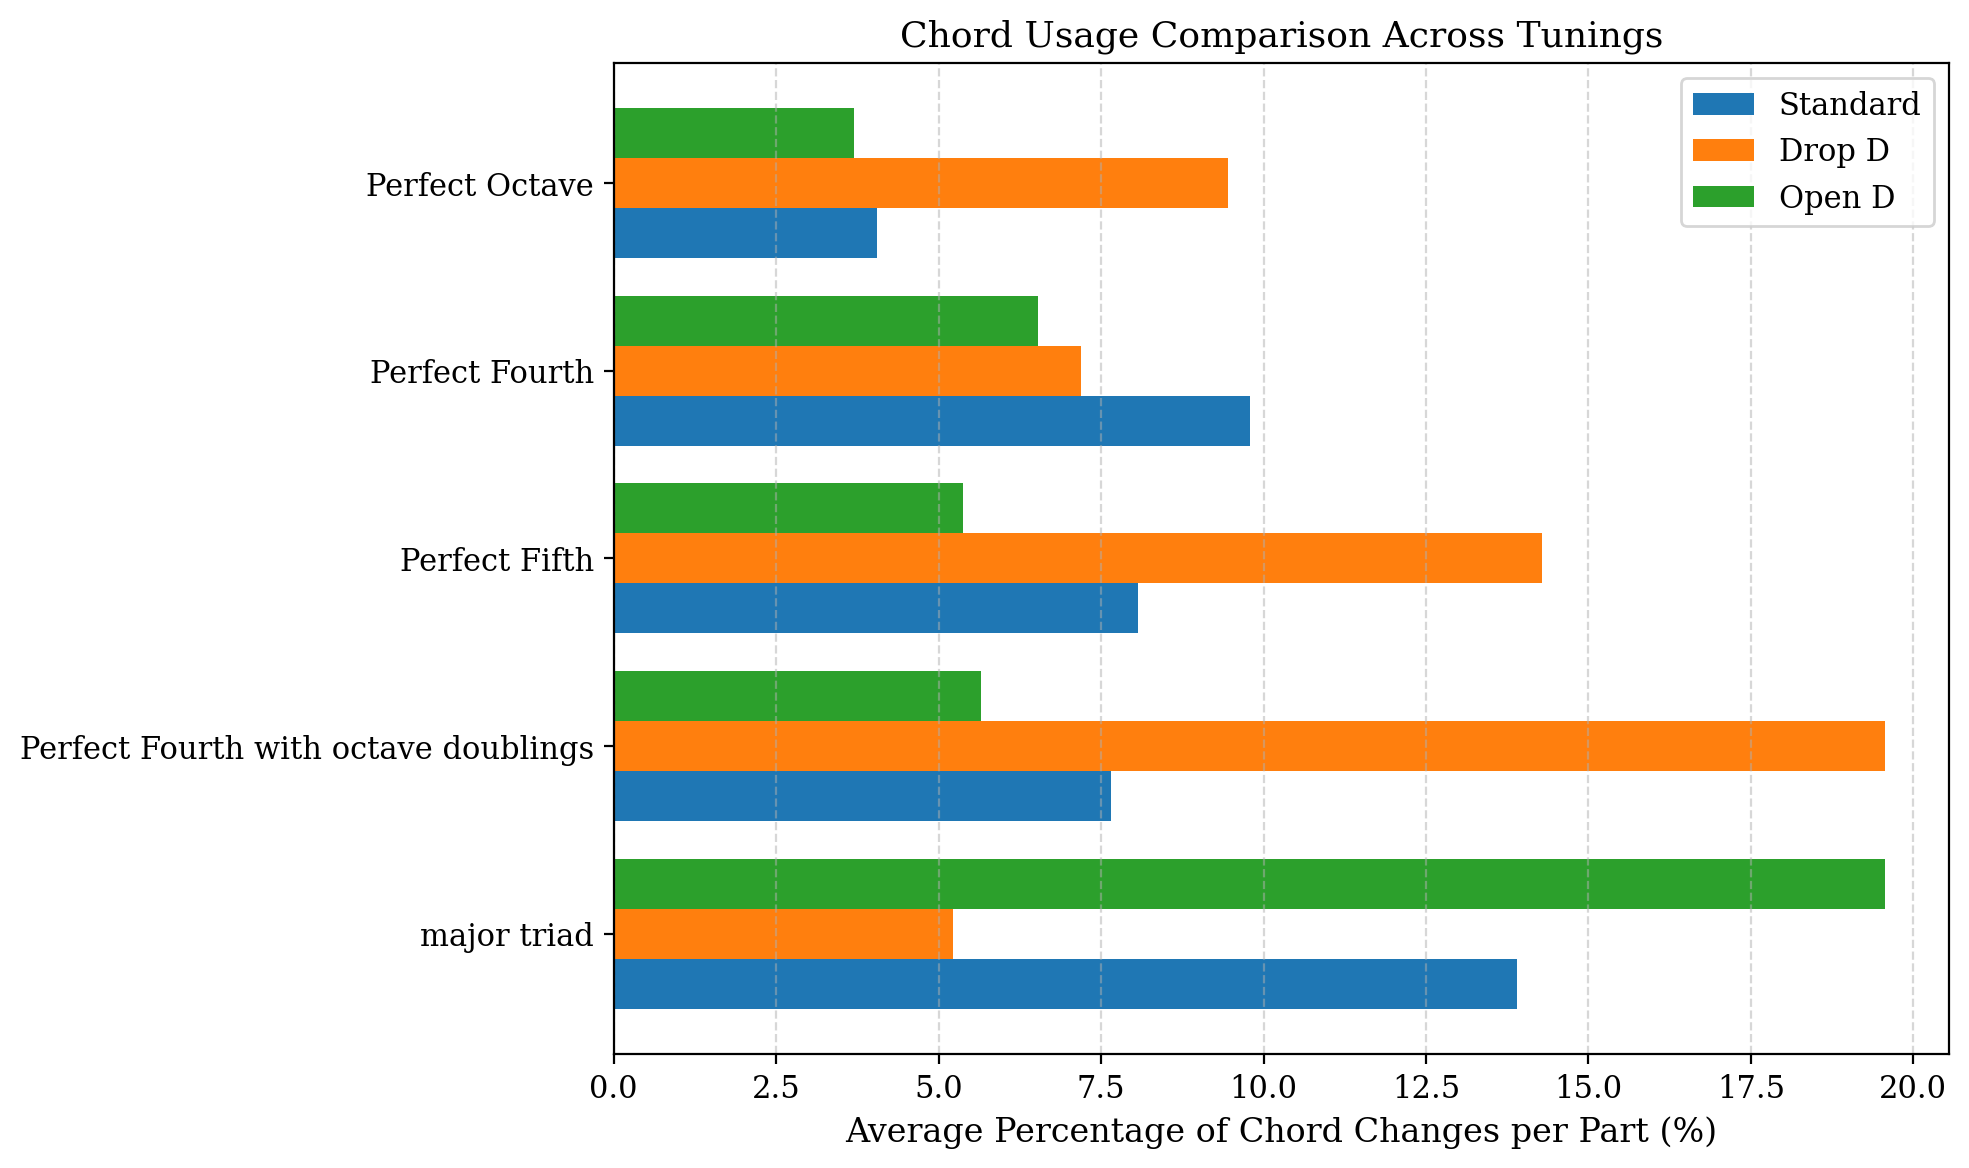

In [49]:
import numpy as np
import matplotlib.pyplot as plt
import os

def plot_horizontal_bar_comparison(tuning_chord_dict, topn=5, save_path=None):
    """
    Shows horizontal grouped bar chart comparing top N chord changes across tunings.
    Optionally saves the plot to `save_path`.
    """
    setup_nice_plot()

    # Find top N global chords across all tunings
    all_chords = {}
    for chord_changes in tuning_chord_dict.values():
        for chord, value in chord_changes.items():
            all_chords[chord] = all_chords.get(chord, 0) + value
    top_chords = sorted(all_chords.items(), key=lambda x: x[1], reverse=True)[:topn]
    selected_chords = [chord for chord, _ in top_chords]

    tunings = list(tuning_chord_dict.keys())
    n_tunings = len(tunings)
    indices = np.arange(topn)
    bar_width = 0.8 / n_tunings

    plt.figure(figsize=(10, 6))
    for i, tuning in enumerate(tunings):
        chord_changes = tuning_chord_dict[tuning]
        values = [chord_changes.get(chord, 0) for chord in selected_chords]
        plt.barh(indices + i * bar_width, values, height=bar_width, label=tuning)

    plt.yticks(indices + bar_width * (n_tunings - 1) / 2, selected_chords)
    plt.xlabel('Average Percentage of Chord Changes per Part (%)')
    plt.title('Chord Usage Comparison Across Tunings')
    plt.legend()
    plt.grid(axis='x', linestyle='--', alpha=0.5)
    plt.tight_layout()

    if save_path:
        os.makedirs(os.path.dirname(save_path), exist_ok=True)
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Figure saved to {save_path}")

    plt.show()


plot_horizontal_bar_comparison(
    tuning_chord_dict,
    topn=5,
    save_path='figures/chord_comparison_top5.png'
)


In [44]:
def get_root_chord_changes(parts_with_target_guitar, normalise=True, strip_octave=True):
    """
    Get root note changes across a list of parts. Normalises by number of changes per part if desired.
    """
    chord_changes = defaultdict(float)

    for part in parts_with_target_guitar:
        chords = part.chordify()
        last_root = None
        part_changes = defaultdict(float)

        for element in chords.flat.notes:
            if isinstance(element, music21.chord.Chord):
                root = element.root()
                name = root.name if strip_octave else root.nameWithOctave

                if name != last_root:
                    part_changes[name] += 1
                    last_root = name

        # Normalize for this part
        if normalise:
            total = sum(part_changes.values())
            for key in part_changes:
                part_changes[key] = (part_changes[key] / total) * 100 if total > 0 else 0

        # Add to overall counts
        for key in part_changes:
            chord_changes[key] += part_changes[key]

    if normalise:
        # Average across number of parts
        num_parts = len(parts_with_target_guitar)
        for key in chord_changes:
            chord_changes[key] /= num_parts

    return dict(chord_changes)

def plot_root_chord_changes(root_chord_dict, tuning_name="Tuning", topn=10, normalise=True):
    """
    Plot horizontal bar chart of root note chord change percentages.
    """
    sorted_roots = sorted(root_chord_dict.items(), key=lambda x: x[1], reverse=True)[:topn]
    labels = [item[0] for item in sorted_roots]
    values = [item[1] for item in sorted_roots]

    plt.figure(figsize=(8, 5))
    bars = plt.barh(range(len(values)), values, color='mediumseagreen', edgecolor='black')
    plt.yticks(range(len(labels)), labels)
    plt.xlabel('Average Percentage of Root Changes per Part (%)' if normalise else 'Root Change Count')
    plt.title(f'Top {topn} Root Note Changes ({tuning_name})')
    plt.gca().invert_yaxis()  # most common on top
    plt.grid(axis='x', linestyle='--', alpha=0.5)

    # Annotate bars
    for i, bar in enumerate(bars):
        value = values[i]
        plt.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                 f'{value:.2f}' if normalise else str(int(value)),
                 va='center', fontsize=9)

    plt.tight_layout()
    plt.show()

def plot_root_changes_comparison_single_figure(tuning_to_root_changes_dict, topn=10, normalise=True):
    """
    Plot a single figure with grouped horizontal bar charts comparing root note chord changes across tunings.

    Parameters:
    - tuning_to_root_changes_dict: dict of {tuning_name: root_change_dict}
    - topn: number of top roots to display (based on overall popularity across all tunings)
    - normalise: whether values represent percentages
    """
    # Collect all root notes and their summed values across all tunings for global top-n selection
    total_counts = defaultdict(float)
    for root_dict in tuning_to_root_changes_dict.values():
        for root, value in root_dict.items():
            total_counts[root] += value

    # Select top N most common roots overall
    top_roots = [root for root, _ in sorted(total_counts.items(), key=lambda x: x[1], reverse=True)[:topn]]

    tuning_names = list(tuning_to_root_changes_dict.keys())
    num_tunings = len(tuning_names)
    bar_width = 0.8 / num_tunings  # Adjust bar width for grouped bars

    fig, ax = plt.subplots(figsize=(10, 6))

    for i, (tuning, root_dict) in enumerate(tuning_to_root_changes_dict.items()):
        values = [root_dict.get(root, 0) for root in top_roots]
        positions = [j + i * bar_width for j in range(len(top_roots))]
        bars = ax.barh(positions, values, height=bar_width, label=tuning, edgecolor='black')

        # Annotate bars
        for j, bar in enumerate(bars):
            val = values[j]
            ax.text(bar.get_width() + 0.5, bar.get_y() + bar.get_height() / 2,
                    f'{val:.2f}' if normalise else str(int(val)),
                    va='center', fontsize=8)

    # Set y-axis labels and ticks
    ax.set_yticks([j + (num_tunings - 1) * bar_width / 2 for j in range(len(top_roots))])
    ax.set_yticklabels(top_roots)
    ax.set_xlabel('Average Percentage of Chord Root per Part (%)' if normalise else 'Count')
    ax.set_title('Chord Root Note Frequency Across Tunings')
    ax.invert_yaxis()
    ax.grid(axis='x', linestyle='--', alpha=0.5)
    ax.legend()

    plt.tight_layout()
    plt.show()


In [132]:
test = get_root_chord_changes(tuning_parts_dict["Drop C"])

/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


In [135]:
print(len(test))

50


/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


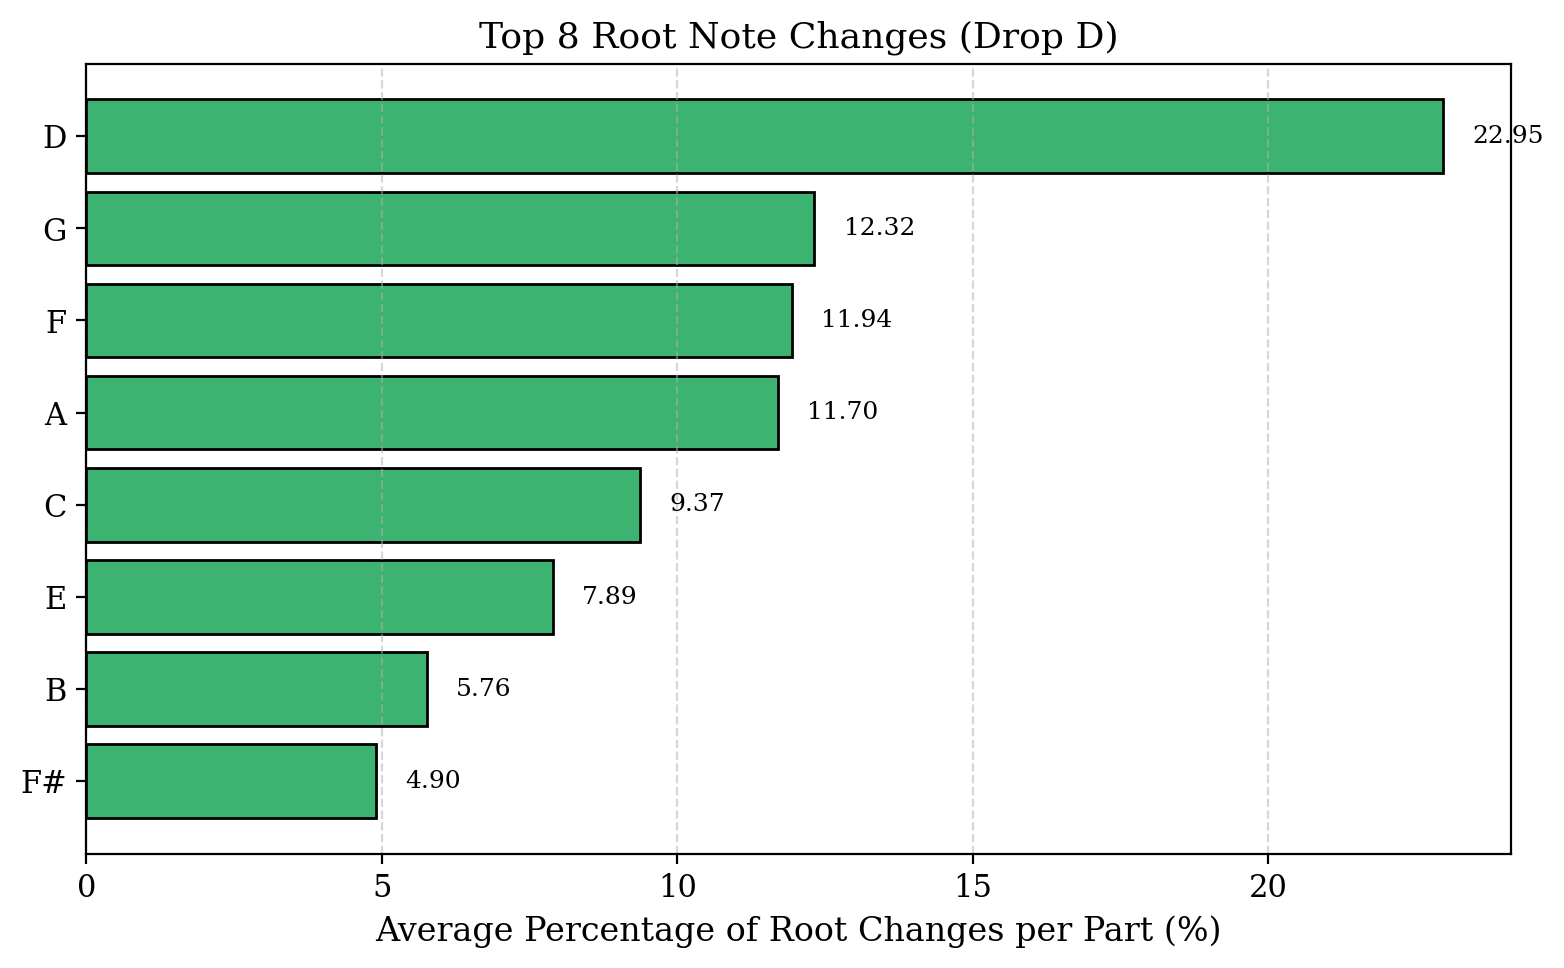

In [45]:
root_changes_dropd = get_root_chord_changes(tuning_parts_dict["Drop D"])
plot_root_chord_changes(root_changes_dropd, tuning_name="Drop D", topn=8)

/home/am/Documents/upf_smc/yr1/amplab/ug-dataset/.venv/lib/python3.11/site-packages/music21/stream/base.py:3675: Music21DeprecationWarning: .flat is deprecated.  Call .flatten() instead
  return self.iter().getElementsByClass(classFilterList)


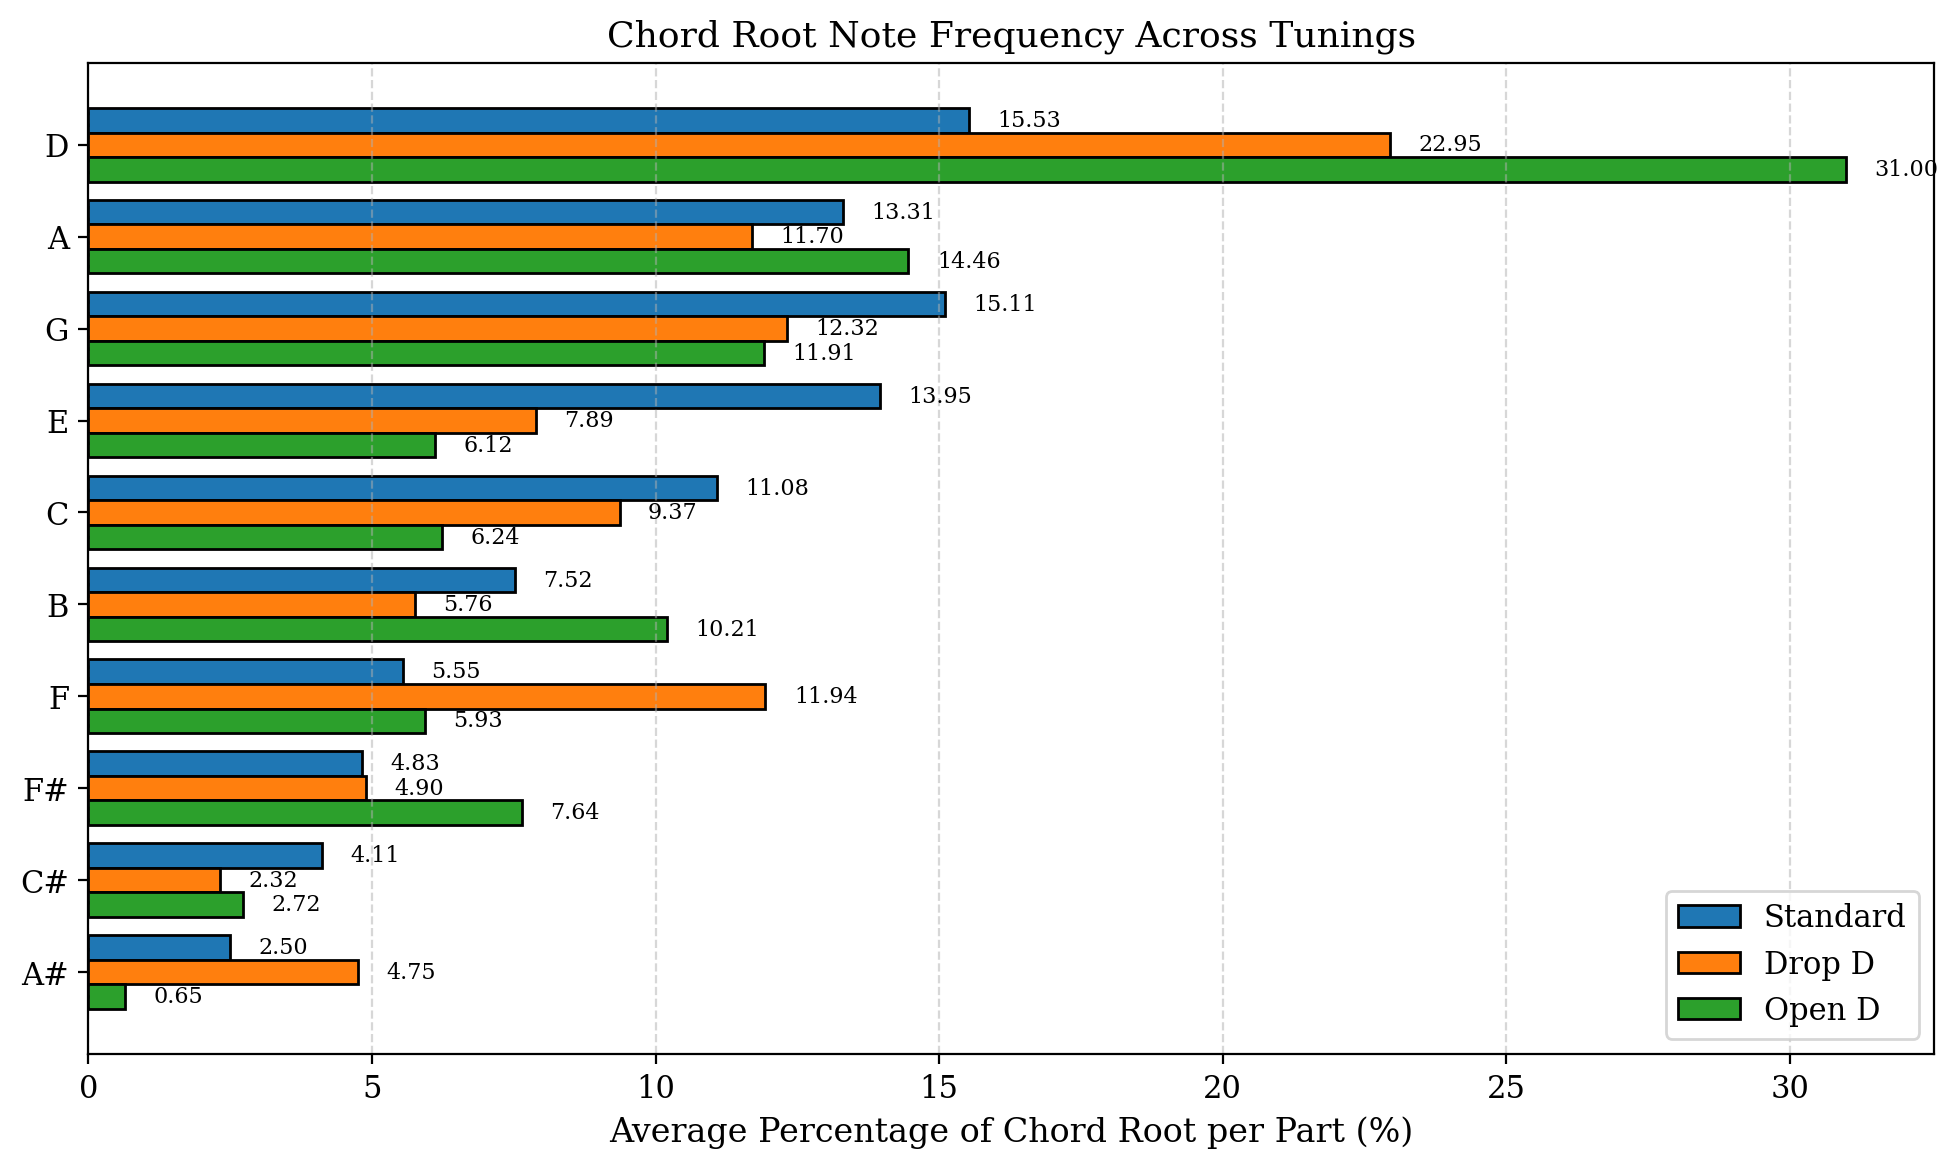

In [46]:
root_changes_dict = {
    "Standard": get_root_chord_changes(tuning_parts_dict["Standard"]),
    "Drop D": get_root_chord_changes(tuning_parts_dict["Drop D"]),
    "Open D": get_root_chord_changes(tuning_parts_dict["Open D"])
}

plot_root_changes_comparison_single_figure(root_changes_dict, topn=10)